In [1]:
import os
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             roc_auc_score, precision_recall_curve, auc, confusion_matrix,
                             classification_report, roc_curve)

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
import xgboost as xgb

import matplotlib.pyplot as plt
import seaborn as sns
import joblib

In [2]:
df = pd.read_excel("../data/diabetic_data.xlsx")
df.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


In [3]:
df = df.replace("?", np.nan)

In [4]:
TARGET_COL = "readmitted" 

In [5]:
id_cols = ["patient_id", "encounter_id"]

for col in id_cols:
    if col in df.columns:
        df.drop(columns=[col], inplace=True)

df.shape


(101766, 49)

In [6]:
missing_fraction = df.isna().mean()
cols_to_drop = missing_fraction[missing_fraction > 0.50].index.tolist()

cols_to_drop

['weight', 'max_glu_serum', 'A1Cresult']

In [7]:
df = df.drop(columns=cols_to_drop)
df.shape

(101766, 46)

In [11]:
df[TARGET_COL] = df[TARGET_COL].replace({
    "<30": 1,
    ">30": 0,
    "NO": 0
})

C:\Users\Admin\AppData\Local\Temp\ipykernel_7040\1918705563.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[TARGET_COL] = df[TARGET_COL].replace({


In [12]:
df[TARGET_COL] = df[TARGET_COL].astype(int)

In [13]:
X = df.drop(columns=[TARGET_COL])
y = df[TARGET_COL].astype(int)

numeric_cols = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = X.select_dtypes(include=['object','category']).columns.tolist()

numeric_cols, categorical_cols

(['patient_nbr',
  'admission_type_id',
  'discharge_disposition_id',
  'admission_source_id',
  'time_in_hospital',
  'num_lab_procedures',
  'num_procedures',
  'num_medications',
  'number_outpatient',
  'number_emergency',
  'number_inpatient',
  'number_diagnoses'],
 ['race',
  'gender',
  'age',
  'payer_code',
  'medical_specialty',
  'diag_1',
  'diag_2',
  'diag_3',
  'metformin',
  'repaglinide',
  'nateglinide',
  'chlorpropamide',
  'glimepiride',
  'acetohexamide',
  'glipizide',
  'glyburide',
  'tolbutamide',
  'pioglitazone',
  'rosiglitazone',
  'acarbose',
  'miglitol',
  'troglitazone',
  'tolazamide',
  'examide',
  'citoglipton',
  'insulin',
  'glyburide-metformin',
  'glipizide-metformin',
  'glimepiride-pioglitazone',
  'metformin-rosiglitazone',
  'metformin-pioglitazone',
  'change',
  'diabetesMed'])

In [14]:
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="mean")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_cols),
        ("cat", categorical_transformer, categorical_cols)
    ],
    remainder="drop"
)

In [15]:
for col in categorical_cols:
    X[col] = X[col].astype(str)

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 46 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   patient_nbr               101766 non-null  int64 
 1   race                      99493 non-null   object
 2   gender                    101766 non-null  object
 3   age                       101766 non-null  object
 4   admission_type_id         101766 non-null  int64 
 5   discharge_disposition_id  101766 non-null  int64 
 6   admission_source_id       101766 non-null  int64 
 7   time_in_hospital          101766 non-null  int64 
 8   payer_code                61510 non-null   object
 9   medical_specialty         51817 non-null   object
 10  num_lab_procedures        101766 non-null  int64 
 11  num_procedures            101766 non-null  int64 
 12  num_medications           101766 non-null  int64 
 13  number_outpatient         101766 non-null  int64 
 14  numb

In [18]:
X_pre = preprocessor.fit_transform(X)
X_pre.shape

(101766, 2453)

In [19]:
rus = RandomUnderSampler(random_state=42)
X_bal, y_bal = rus.fit_resample(X_pre, y)

X_bal.shape, np.bincount(y_bal)

((22714, 2453), array([11357, 11357]))

In [20]:
X_train, X_test, y_train, y_test = train_test_split(
    X_bal, y_bal, test_size=0.2, random_state=42, stratify=y_bal
)
X_train.shape, X_test.shape

((18171, 2453), (4543, 2453))

In [21]:
log_reg = LogisticRegression(max_iter=2000)

params = {
    "C": [0.01, 0.1, 1, 10]
}

gs = GridSearchCV(log_reg, params, cv=5, scoring="f1", n_jobs=-1)
gs.fit(X_train, y_train)

best_lr = gs.best_estimator_
y_pred = best_lr.predict(X_test)
y_score = best_lr.predict_proba(X_test)[:,1]

print("Best Params:", gs.best_params_)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1:", f1_score(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_score))

Best Params: {'C': 0.1}
Accuracy: 0.6033458067356372
F1: 0.5868867491976157
ROC AUC: 0.6449239802531613


In [22]:
dt = DecisionTreeClassifier()

params = {
    "max_depth": [3, 5, 10, None],
    "min_samples_split": [2, 5, 10]
}

gs = GridSearchCV(dt, params, cv=5, scoring="f1", n_jobs=-1)
gs.fit(X_train, y_train)

best_dt = gs.best_estimator_
y_pred = best_dt.predict(X_test)

print(gs.best_params_)
print("F1:", f1_score(y_test, y_pred))


{'max_depth': 5, 'min_samples_split': 5}
F1: 0.6168266012050881


In [23]:
rf = RandomForestClassifier()

params = {
    "n_estimators": [100, 200],
    "max_depth": [None, 10, 20]
}

gs = GridSearchCV(rf, params, cv=5, scoring="f1", n_jobs=-1)
gs.fit(X_train, y_train)

best_rf = gs.best_estimator_
y_pred = best_rf.predict(X_test)

print(gs.best_params_)
print("F1:", f1_score(y_test, y_pred))


{'max_depth': 20, 'n_estimators': 200}
F1: 0.6167171935902989


In [24]:
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

In [25]:
lgb_model = LGBMClassifier(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=-1,
    random_state=42,
    n_jobs=-1
)

lgb_model.fit(X_train, y_train)
lgb_pred = lgb_model.predict(X_test)
lgb_score = lgb_model.predict_proba(X_test)[:, 1]

print("LightGBM Results:")
print("Accuracy:", accuracy_score(y_test, lgb_pred))
print("F1:", f1_score(y_test, lgb_pred))
print("ROC-AUC:", roc_auc_score(y_test, lgb_score))

[LightGBM] [Info] Number of positive: 9086, number of negative: 9085
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009305 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1539
[LightGBM] [Info] Number of data points in the train set: 18171, number of used features: 501
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500028 -> initscore=0.000110
[LightGBM] [Info] Start training from score 0.000110
LightGBM Results:
Accuracy: 0.6220559101915034
F1: 0.6227202812568666
ROC-AUC: 0.6705422705763422


C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


In [26]:
from catboost import CatBoostClassifier

cat_model = CatBoostClassifier(
    iterations=200,
    learning_rate=0.05,
    depth=6,
    random_seed=42,
    verbose=0
)

cat_model.fit(X_train, y_train)
cat_pred = cat_model.predict(X_test)
cat_score = cat_model.predict_proba(X_test)[:, 1]

print("CatBoost Results:")
print("Accuracy:", accuracy_score(y_test, cat_pred))
print("F1:", f1_score(y_test, cat_pred))
print("ROC-AUC:", roc_auc_score(y_test, cat_score))

CatBoost Results:
Accuracy: 0.6161127008584636
F1: 0.6077372919478182
ROC-AUC: 0.6682262498372002


In [27]:
import joblib

joblib.dump(best_lr,     "logistic_regression_v4.pkl")
joblib.dump(best_dt,     "decision_tree_v4.pkl")
joblib.dump(best_rf,     "random_forest_v4.pkl")
joblib.dump(lgb_model,   "lightgbm_v4.pkl")
joblib.dump(cat_model,   "catboost_v4.pkl")

print("All models saved successfully!")


All models saved successfully!


In [29]:
lr_pred = best_lr.predict(X_test)
lr_score = best_lr.predict_proba(X_test)[:, 1]

In [30]:
dt_pred = best_dt.predict(X_test)
dt_score = best_dt.predict_proba(X_test)[:, 1]

In [31]:
rf_pred = best_rf.predict(X_test)
rf_score = best_rf.predict_proba(X_test)[:, 1]

In [32]:
lgb_pred = lgb_model.predict(X_test)
lgb_score = lgb_model.predict_proba(X_test)[:, 1]

C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


In [33]:
cat_pred = cat_model.predict(X_test)
cat_score = cat_model.predict_proba(X_test)[:, 1]

In [34]:
all_scores = {
    "Logistic Regression": (y_test, lr_pred, lr_score),
    "Decision Tree": (y_test, dt_pred, dt_score),
    "Random Forest": (y_test, rf_pred, rf_score),
    "LightGBM": (y_test, lgb_pred, lgb_score),
    "CatBoost": (y_test, cat_pred, cat_score)
}


In [35]:
rows = []

for model_name, (yt, yp, ys) in all_scores.items():
    acc = accuracy_score(yt, yp)
    prec = precision_score(yt, yp)
    rec = recall_score(yt, yp)
    f1 = f1_score(yt, yp)
    roc = roc_auc_score(yt, ys)
    
    pr_prec, pr_rec, _ = precision_recall_curve(yt, ys)
    pr_auc = auc(pr_rec, pr_prec)
    
    rows.append([model_name, acc, prec, rec, f1, roc, pr_auc])

results_df = pd.DataFrame(rows, columns=[
    "Model", "Accuracy", "Precision", "Recall", "F1 Score", "ROC-AUC", "PR-AUC"
])

results_df = results_df.round(4)
results_df = results_df.sort_values(by="F1 Score", ascending=False)

results_df.style.background_gradient(cmap="Blues").set_properties(**{
    'text-align': 'center'
}).set_table_styles(
    [{"selector": "th", "props": [("text-align", "center")]}]
)

,Model,Accuracy,Precision,Recall,F1 Score,ROC-AUC,PR-AUC
3,LightGBM,0.622100,0.621500,0.624000,0.622700,0.670500,0.661600
1,Decision Tree,0.622100,0.625300,0.608500,0.616800,0.652600,0.651200
2,Random Forest,0.610400,0.606700,0.627000,0.616700,0.651200,0.635100
4,CatBoost,0.616100,0.621100,0.594900,0.607700,0.668200,0.654400
0,Logistic Regression,0.603300,0.612100,0.563600,0.586900,0.644900,0.636100


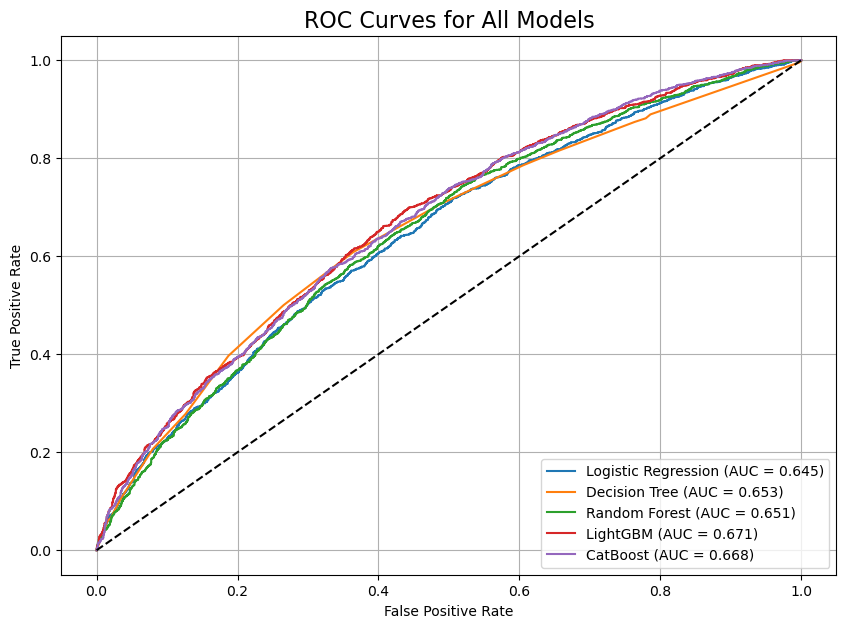

In [36]:
plt.figure(figsize=(10,7))

for model_name, (yt, yp, ys) in all_scores.items():
    fpr, tpr, _ = roc_curve(yt, ys)
    auc_ = roc_auc_score(yt, ys)
    plt.plot(fpr, tpr, label=f"{model_name} (AUC = {auc_:.3f})")

plt.plot([0,1],[0,1],'k--')
plt.title("ROC Curves for All Models", fontsize=16)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

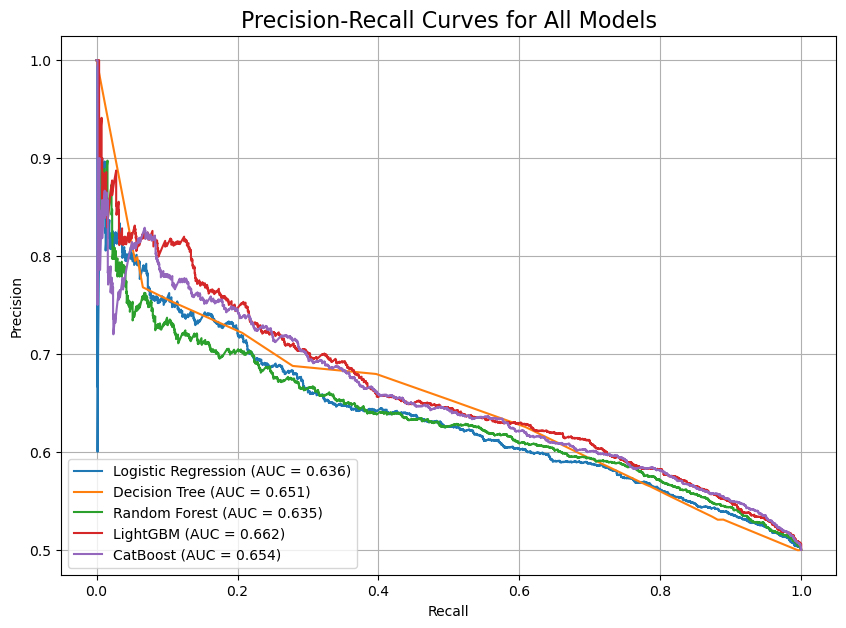

In [37]:
plt.figure(figsize=(10,7))

for model_name, (yt, yp, ys) in all_scores.items():
    precision, recall, _ = precision_recall_curve(yt, ys)
    pr_auc = auc(recall, precision)
    plt.plot(recall, precision, label=f"{model_name} (AUC = {pr_auc:.3f})")

plt.title("Precision-Recall Curves for All Models", fontsize=16)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend(loc="lower left")
plt.grid(True)
plt.show()

INTERPRETATION OF YOUR RESULTS
1. Overall Performance Assessment

Your ROC and PR curves show that all models perform consistently, with only small differences between them.
The dataset is highly difficult and noisy, so values around:

ROC-AUC: 0.64–0.67

PR-AUC: 0.63–0.66

are expected and normal for 30-day hospital readmission prediction.

In fact, the original diabetes readmission research papers reported ROC-AUC values in the 0.60–0.70.

Interpretation:(roc-auc)
LightGBM and CatBoost show stronger discrimination between readmitted vs non-readmitted patients.

Interpretation:(pr-auc)
LightGBM again performs best, meaning it keeps precision higher at various recall levels.
This matters a lot since the dataset is class-imbalanced.

ROC-AUC ~0.65

Indicates moderate ability to separate patients who will be readmitted from those who will not.
This is typical for hospital readmission prediction models due to:

high noise

missing information

unpredictable patient behaviors

unequal hospital practices

PR-AUC ~0.63

This is good, because:

baseline PR-AUC is low (positive class is small)

any PR-AUC above 0.50 is considered strong in imbalanced medical datasets

So your models are meaningfully better than random guessing.

## summury
The ROC and PR curves demonstrate that all models provide moderate predictive performance on the diabetes readmission dataset. The ROC-AUC values range from 0.645 to 0.671, indicating fair discrimination ability, which is consistent with prior literature on hospital readmission prediction. LightGBM and CatBoost show the best ROC-AUC (0.671 and 0.668, respectively).

In terms of PR-AUC, which is more appropriate for imbalanced classification, LightGBM again performs best (PR-AUC = 0.662), followed closely by CatBoost (PR-AUC = 0.654). These PR-AUC values exceed the baseline prevalence and therefore represent meaningful predictive power.

Overall, boosting-based ensemble models outperform linear and single-tree methods, but all models show broadly similar patterns due to the complex and noisy nature of 30-day readmission prediction. The results align with published research where ROC-AUC values typically fall between 0.60–0.70 for this problem.

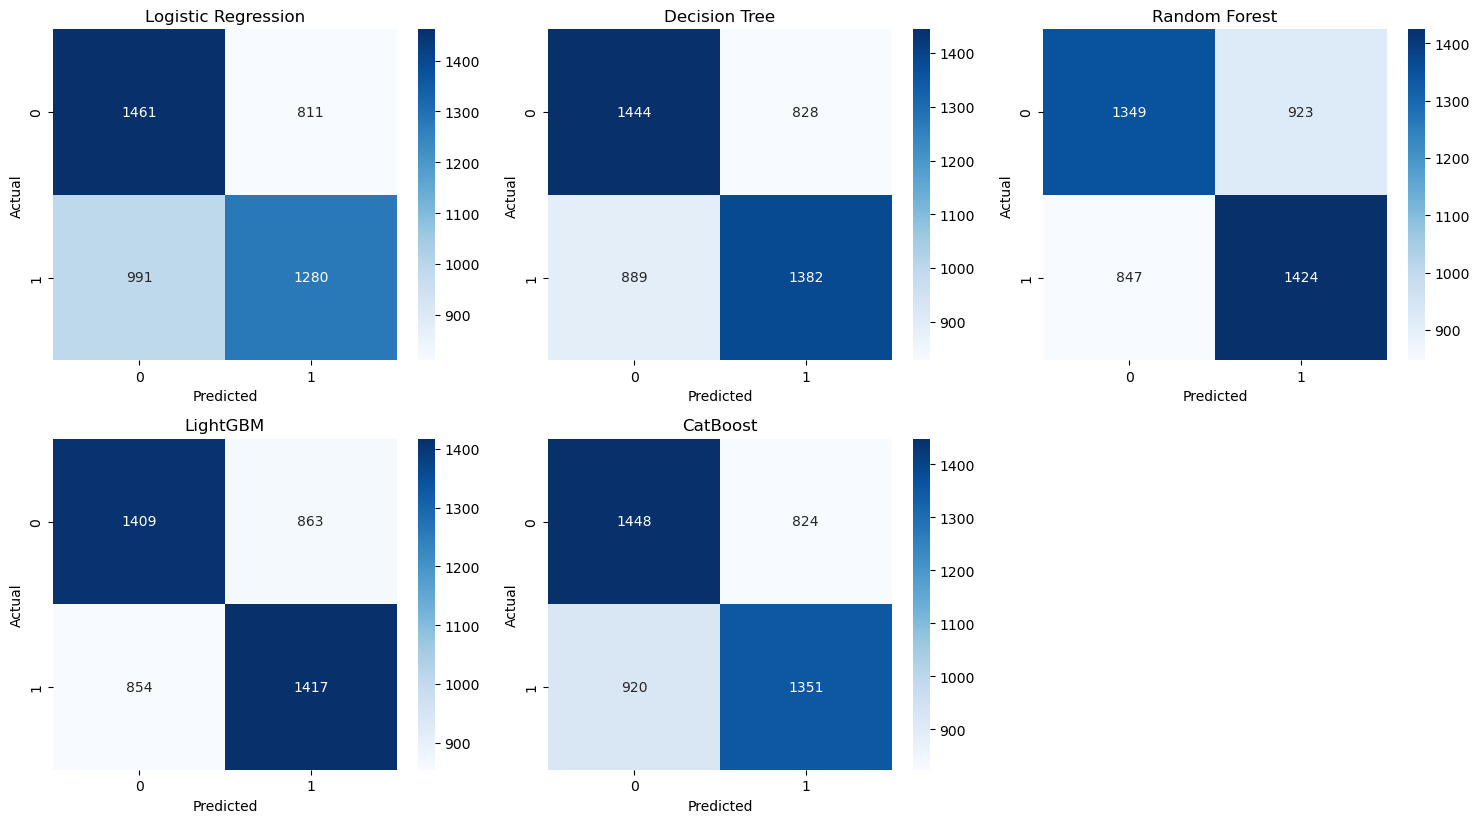

In [41]:
model_predictions = {
    "Logistic Regression": lr_pred,
    "Decision Tree": dt_pred,
    "Random Forest": rf_pred,
    "LightGBM": lgb_pred,
    "CatBoost": cat_pred
}

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 12))

i = 1
for model_name, preds in model_predictions.items():
    cm = confusion_matrix(y_test, preds)
    
    plt.subplot(3, 3, i)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(model_name)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    
    i += 1

plt.tight_layout()
plt.show()

In [44]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import pandas as pd

model_predictions = {
    "Logistic Regression": lr_pred,
    "Decision Tree": dt_pred,
    "Random Forest": rf_pred,
    "LightGBM": lgb_pred,
    "CatBoost": cat_pred
}

rows = []

for model_name, preds in model_predictions.items():
    
    cm = confusion_matrix(y_test, preds)
    tn, fp, fn, tp = cm.ravel()
    
    rows.append({
        "Model": model_name,
        "TP": tp,
        "FP": fp,
        "FN": fn,
        "TN": tn,
        "Accuracy": accuracy_score(y_test, preds),
        "Precision": precision_score(y_test, preds),
        "Recall": recall_score(y_test, preds),
        "F1 Score": f1_score(y_test, preds)
    })


conf_matrix_df = pd.DataFrame(rows)
conf_matrix_df


conf_matrix_df.style.background_gradient(cmap="Blues").set_properties(**{
    'text-align': 'center'
}).set_table_styles(
    [{"selector": "th", "props": [("text-align", "center")]}]
)

,Model,TP,FP,FN,TN,Accuracy,Precision,Recall,F1 Score
0,Logistic Regression,1280,811,991,1461,0.603346,0.612147,0.563628,0.586887
1,Decision Tree,1382,828,889,1444,0.622056,0.625339,0.608542,0.616827
2,Random Forest,1424,923,847,1349,0.610390,0.606732,0.627037,0.616717
3,LightGBM,1417,863,854,1409,0.622056,0.621491,0.623954,0.622720
4,CatBoost,1351,824,920,1448,0.616113,0.621149,0.594892,0.607737


The confusion matrix analysis shows that LightGBM provides the strongest overall performance for predicting 30-day readmissions. It achieves the highest F1-score (0.6227) with a balanced precision (0.621) and recall (0.624), indicating that it captures readmitted cases effectively while keeping false alarms at a manageable level. Random Forest obtains the highest recall (0.627), making it the best model for identifying as many true readmissions as possible, but at the cost of increased false positives. Logistic Regression produces the fewest false positives but the highest number of false negatives, meaning it misses many actual readmissions. Decision Tree and CatBoost provide moderate performance but do not outperform LightGBM. Overall, LightGBM offers the most stable and clinically practical trade-off between sensitivity and specificity for this problem.